In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [43]:
tf.random.set_seed(221)

In [44]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [45]:
dataset = pd.read_csv('../../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [46]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [47]:
# specify the number of lag hours
n_hours = 24*3
K = 48
S = 48

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [48]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96313, 480)


In [49]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+45),var4(t+45),var1(t+46),var2(t+46),var3(t+46),var4(t+46),var1(t+47),var2(t+47),var3(t+47),var4(t+47)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,0.18,0.14,0.60,0.74,0.77,0.70,1.13,1.28,1.30,1.25
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,0.77,0.70,1.13,1.28,1.30,1.25,1.55,1.71,1.73,1.67
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,1.30,1.25,1.55,1.71,1.73,1.67,1.75,1.91,1.93,1.86
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,1.73,1.67,1.75,1.91,1.93,1.86,1.74,1.92,1.93,1.89
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.93,1.86,1.74,1.92,1.93,1.89,1.29,1.53,1.50,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/29/20 20:00,1.50,1.55,1.63,1.570,0.99,1.00,1.12,1.06,0.55,0.64,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/29/20 21:00,0.99,1.00,1.12,1.060,0.55,0.64,0.68,0.60,0.11,0.09,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/29/20 22:00,0.55,0.64,0.68,0.600,0.11,0.09,0.23,0.15,-0.21,-0.21,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [50]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96313, 720)


In [51]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+46),var4(t+46),var5(t+46),var6(t+46),var1(t+47),var2(t+47),var3(t+47),var4(t+47),var5(t+47),var6(t+47)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.77,0.00,2.70,0.0,2.07,0.0,2.78,0.00,2.72
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.78,0.00,2.72,0.0,2.07,0.0,2.77,0.00,2.72
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.77,0.00,2.72,0.0,2.07,0.0,2.76,0.00,2.73
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.76,0.00,2.73,0.0,2.08,0.0,2.76,0.00,2.75
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.76,0.00,2.75,0.0,2.09,0.0,2.75,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/29/20 20:00,0.0,1.95,315.38,2.49,382.06,2.45,0.0,1.95,394.38,2.46,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/29/20 21:00,0.0,1.95,394.38,2.46,467.78,2.35,0.0,1.95,449.33,2.43,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/29/20 22:00,0.0,1.95,449.33,2.43,0.00,2.64,0.0,1.94,499.27,2.38,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [52]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96313, 1080)


In [53]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+46),var1(t+47),var2(t+47),var3(t+47),var4(t+47),var5(t+47),var6(t+47),var7(t+47),var8(t+47),var9(t+47)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.28,...,0.0,1.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.73,...,0.0,1.64,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.85,...,0.0,1.82,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.49,...,0.0,1.75,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.21,...,0.0,1.29,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/29/20 20:00,1.33,0.0,0.0,2.57,0.0,0.0,2.62,0.0,0.0,0.87,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/29/20 21:00,0.87,0.0,0.0,2.57,0.0,0.0,2.62,0.0,0.0,0.47,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/29/20 22:00,0.47,0.0,0.0,2.57,0.0,0.0,0.00,0.0,0.0,-0.01,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [54]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96313, 1800)


In [55]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [56]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/29/20 20:00,0.0,1.95,315.38,2.49,382.06,2.45,1.33,0.0,0.0,2.57,...,2.46,1.68,0.0,0.0,2.57,0.0,0.0,2.6,0.0,0.0
12/29/20 21:00,0.0,1.95,394.38,2.46,467.78,2.35,0.87,0.0,0.0,2.57,...,2.50,1.88,0.0,0.0,2.57,0.0,0.0,2.6,0.0,0.0
12/29/20 22:00,0.0,1.95,449.33,2.43,0.00,2.64,0.47,0.0,0.0,2.57,...,2.50,1.88,0.0,0.0,2.57,0.0,0.0,2.6,0.0,0.0


#### all target water stages in past $w$ hours

In [57]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [58]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/29/20 20:00,1.50,1.55,1.63,1.570,0.99,1.00,1.12,1.06,0.55,0.64,...,0.89,0.86,1.25,1.24,1.31,1.29,1.68,1.72,1.76,1.72
12/29/20 21:00,0.99,1.00,1.12,1.060,0.55,0.64,0.68,0.60,0.11,0.09,...,1.31,1.29,1.68,1.72,1.76,1.72,1.95,1.92,1.99,1.98
12/29/20 22:00,0.55,0.64,0.68,0.600,0.11,0.09,0.23,0.15,-0.21,-0.21,...,1.76,1.72,1.95,1.92,1.99,1.98,1.96,1.94,2.03,2.01


#### merge all data (ws, covariates) in past $w$ hours

In [59]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [60]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [61]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96308,0.0,1.95,315.38,2.49,382.06,2.45,1.33,0.0,0.0,2.57,...,2.57,0.0,0.0,2.6,0.0,0.0,1.68,1.72,1.76,1.72
96309,0.0,1.95,394.38,2.46,467.78,2.35,0.87,0.0,0.0,2.57,...,2.57,0.0,0.0,2.6,0.0,0.0,1.95,1.92,1.99,1.98
96310,0.0,1.95,449.33,2.43,0.00,2.64,0.47,0.0,0.0,2.57,...,2.57,0.0,0.0,2.6,0.0,0.0,1.96,1.94,2.03,2.01
96311,0.0,1.94,499.27,2.38,0.00,2.66,-0.01,0.0,0.0,2.57,...,2.57,0.0,0.0,2.6,0.0,0.0,1.62,1.65,1.75,1.72


#### shift prior known covariates in future  $S$ steps to the past

In [62]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-24),shift_prior_known_supervised_var2(t-24),shift_prior_known_supervised_var3(t-24),shift_prior_known_supervised_var4(t-24),shift_prior_known_supervised_var5(t-24),shift_prior_known_supervised_var6(t-24),shift_prior_known_supervised_var7(t-24),shift_prior_known_supervised_var8(t-24),shift_prior_known_supervised_var9(t-24),shift_prior_known_supervised_var1(t-23),...,shift_prior_known_supervised_var9(t+46),shift_prior_known_supervised_var1(t+47),shift_prior_known_supervised_var2(t+47),shift_prior_known_supervised_var3(t+47),shift_prior_known_supervised_var4(t+47),shift_prior_known_supervised_var5(t+47),shift_prior_known_supervised_var6(t+47),shift_prior_known_supervised_var7(t+47),shift_prior_known_supervised_var8(t+47),shift_prior_known_supervised_var9(t+47)
0,1.48,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.78,...,0.0,1.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.78,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.13,...,0.0,1.64,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.48,...,0.0,1.82,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-0.48,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.81,...,0.0,1.75,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.81,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.80,...,0.0,1.29,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96308,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96309,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96310,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96311,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [63]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [64]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [65]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [66]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+47),shift_prior_known_supervised_var2(t+47),shift_prior_known_supervised_var3(t+47),shift_prior_known_supervised_var4(t+47),shift_prior_known_supervised_var5(t+47),shift_prior_known_supervised_var6(t+47),shift_prior_known_supervised_var7(t+47),shift_prior_known_supervised_var8(t+47),shift_prior_known_supervised_var9(t+47)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,1.64,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,1.82,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.75,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,1.29,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96308,0.0,1.95,315.38,2.49,382.06,2.45,1.33,0.0,0.0,2.57,...,1.72,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96309,0.0,1.95,394.38,2.46,467.78,2.35,0.87,0.0,0.0,2.57,...,1.98,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96310,0.0,1.95,449.33,2.43,0.00,2.64,0.47,0.0,0.0,2.57,...,2.01,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96311,0.0,1.94,499.27,2.38,0.00,2.66,-0.01,0.0,0.0,2.57,...,1.72,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [67]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+45),var4(t+45),var1(t+46),var2(t+46),var3(t+46),var4(t+46),var1(t+47),var2(t+47),var3(t+47),var4(t+47)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,0.18,0.14,0.60,0.74,0.77,0.70,1.13,1.28,1.30,1.25
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,0.77,0.70,1.13,1.28,1.30,1.25,1.55,1.71,1.73,1.67
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,1.30,1.25,1.55,1.71,1.73,1.67,1.75,1.91,1.93,1.86
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,1.73,1.67,1.75,1.91,1.93,1.86,1.74,1.92,1.93,1.89
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,1.93,1.86,1.74,1.92,1.93,1.89,1.29,1.53,1.50,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96308,1.95,1.92,1.99,1.98,1.96,1.94,2.03,2.01,1.62,1.65,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96309,1.96,1.94,2.03,2.01,1.62,1.65,1.75,1.72,1.14,1.15,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96310,1.62,1.65,1.75,1.72,1.14,1.15,1.26,1.26,0.73,0.74,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96311,1.14,1.15,1.26,1.26,0.73,0.74,0.84,0.77,0.15,0.19,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [68]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96313, 2208)


In [69]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+45),var4(t+45),var1(t+46),var2(t+46),var3(t+46),var4(t+46),var1(t+47),var2(t+47),var3(t+47),var4(t+47)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.18,0.14,0.60,0.74,0.77,0.70,1.13,1.28,1.30,1.25
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.77,0.70,1.13,1.28,1.30,1.25,1.55,1.71,1.73,1.67
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.30,1.25,1.55,1.71,1.73,1.67,1.75,1.91,1.93,1.86
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,1.73,1.67,1.75,1.91,1.93,1.86,1.74,1.92,1.93,1.89
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,1.93,1.86,1.74,1.92,1.93,1.89,1.29,1.53,1.50,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96308,0.0,1.95,315.38,2.49,382.06,2.45,1.33,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96309,0.0,1.95,394.38,2.46,467.78,2.35,0.87,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96310,0.0,1.95,449.33,2.43,0.00,2.64,0.47,0.0,0.0,2.57,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96311,0.0,1.94,499.27,2.38,0.00,2.66,-0.01,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [70]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77050


In [71]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [72]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77050, 2016) (77050, 192) (19263, 2016) (19263, 192)


In [73]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77050, 72, 28) (77050, 192) (19263, 72, 28) (19263, 192)


### Model

In [80]:
# define model
model_cnn = keras.Sequential()
model_cnn.add(layers.Conv1D(filters=64, 
                            kernel_size=2, 
                            activation='relu', 
                            padding="same", 
                            input_shape=(train_X.shape[1], train_X.shape[2])))

model_cnn.add(layers.Flatten())
# model_cnn.add(layers.Dense(8, activation='relu'))
model_cnn.add(layers.Dense(train_y.shape[1]))
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 72, 64)            3648      
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 192)               884928    
Total params: 888,576
Trainable params: 888,576
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000

Epoch 00001: val_mae improved from inf to 0.19758, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0766 - mae: 0.2208 - val_loss: 0.0617 - val_mae: 0.1976
Epoch 2/2000

Epoch 00002: val_mae improved from 0.19758 to 0.14632, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0231 - mae: 0.1217 - val_loss: 0.0329 - val_mae: 0.1463
Epoch 3/2000

Epoch 00003: val_mae improved from 0.14632 to 0.12849, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0164 - mae: 0.1030 - val_loss: 0.0255 - val_mae: 0.1285
Epoch 4/2000

Epoch 00004: val_mae improved from 0.12849 to 0.11507, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0131 - mae: 0.0915 - val_loss: 0.0207 - val_mae: 0.1151
Epoch 5/2000

Epoch 00005: val_mae improved from 0.11507 to 0.10408, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0107 - mae: 0.0819 - val_loss: 0.0172 - val_mae: 0.1041

Epoch 42/2000

Epoch 00042: val_mae improved from 0.04865 to 0.04817, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0021 - mae: 0.0345 - val_loss: 0.0038 - val_mae: 0.0482
Epoch 43/2000

Epoch 00043: val_mae improved from 0.04817 to 0.04771, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0021 - mae: 0.0341 - val_loss: 0.0037 - val_mae: 0.0477
Epoch 44/2000

Epoch 00044: val_mae improved from 0.04771 to 0.04726, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0020 - mae: 0.0337 - val_loss: 0.0036 - val_mae: 0.0473
Epoch 45/2000

Epoch 00045: val_mae improved from 0.04726 to 0.04683, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0020 - mae: 0.0334 - val_loss: 0.0036 - val_mae: 0.0468
Epoch 46/2000

Epoch 00046: val_mae improved from 0.04683 to 0.04641, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0019 - mae: 0.0330 - val_loss: 0.0035 - val_ma

Epoch 83/2000

Epoch 00083: val_mae improved from 0.03711 to 0.03696, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0011 - mae: 0.0245 - val_loss: 0.0022 - val_mae: 0.0370
Epoch 84/2000

Epoch 00084: val_mae improved from 0.03696 to 0.03680, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0011 - mae: 0.0244 - val_loss: 0.0022 - val_mae: 0.0368
Epoch 85/2000

Epoch 00085: val_mae improved from 0.03680 to 0.03665, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0011 - mae: 0.0242 - val_loss: 0.0022 - val_mae: 0.0366
Epoch 86/2000

Epoch 00086: val_mae improved from 0.03665 to 0.03650, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0011 - mae: 0.0241 - val_loss: 0.0022 - val_mae: 0.0365
Epoch 87/2000

Epoch 00087: val_mae improved from 0.03650 to 0.03635, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 0.0011 - mae: 0.0240 - val_loss: 0.0021 - val_ma

Epoch 123/2000

Epoch 00123: val_mae improved from 0.03262 to 0.03255, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 7.7415e-04 - mae: 0.0203 - val_loss: 0.0017 - val_mae: 0.0325
Epoch 124/2000

Epoch 00124: val_mae improved from 0.03255 to 0.03247, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 7.6857e-04 - mae: 0.0202 - val_loss: 0.0017 - val_mae: 0.0325
Epoch 125/2000

Epoch 00125: val_mae improved from 0.03247 to 0.03240, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 7.6308e-04 - mae: 0.0201 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 126/2000

Epoch 00126: val_mae improved from 0.03240 to 0.03232, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 7.5766e-04 - mae: 0.0201 - val_loss: 0.0017 - val_mae: 0.0323
Epoch 127/2000

Epoch 00127: val_mae improved from 0.03232 to 0.03225, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 7.5232e-04 - mae: 0.0200 - 

Epoch 163/2000

Epoch 00163: val_mae improved from 0.03021 to 0.03017, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 6.0031e-04 - mae: 0.0177 - val_loss: 0.0015 - val_mae: 0.0302
Epoch 164/2000

Epoch 00164: val_mae improved from 0.03017 to 0.03012, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 5.9694e-04 - mae: 0.0177 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 165/2000

Epoch 00165: val_mae improved from 0.03012 to 0.03007, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 5.9362e-04 - mae: 0.0176 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 166/2000

Epoch 00166: val_mae improved from 0.03007 to 0.03002, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 5.9033e-04 - mae: 0.0176 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 167/2000

Epoch 00167: val_mae improved from 0.03002 to 0.02998, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 5.8708e-04 - mae: 0.0175 - 

Epoch 203/2000

Epoch 00203: val_mae improved from 0.02851 to 0.02847, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 4.8949e-04 - mae: 0.0159 - val_loss: 0.0014 - val_mae: 0.0285
Epoch 204/2000

Epoch 00204: val_mae improved from 0.02847 to 0.02843, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 4.8723e-04 - mae: 0.0158 - val_loss: 0.0014 - val_mae: 0.0284
Epoch 205/2000

Epoch 00205: val_mae improved from 0.02843 to 0.02839, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 4.8499e-04 - mae: 0.0158 - val_loss: 0.0014 - val_mae: 0.0284
Epoch 206/2000

Epoch 00206: val_mae improved from 0.02839 to 0.02836, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 4.8277e-04 - mae: 0.0158 - val_loss: 0.0014 - val_mae: 0.0284
Epoch 207/2000

Epoch 00207: val_mae improved from 0.02836 to 0.02832, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 4.8057e-04 - mae: 0.0157 - 

Epoch 243/2000

Epoch 00243: val_mae improved from 0.02709 to 0.02706, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 4.1252e-04 - mae: 0.0144 - val_loss: 0.0012 - val_mae: 0.0271
Epoch 244/2000

Epoch 00244: val_mae improved from 0.02706 to 0.02703, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 4.1090e-04 - mae: 0.0144 - val_loss: 0.0012 - val_mae: 0.0270
Epoch 245/2000

Epoch 00245: val_mae improved from 0.02703 to 0.02700, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 4.0929e-04 - mae: 0.0144 - val_loss: 0.0012 - val_mae: 0.0270
Epoch 246/2000

Epoch 00246: val_mae improved from 0.02700 to 0.02696, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 4.0770e-04 - mae: 0.0144 - val_loss: 0.0012 - val_mae: 0.0270
Epoch 247/2000

Epoch 00247: val_mae improved from 0.02696 to 0.02693, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 4.0612e-04 - mae: 0.0143 - 

Epoch 283/2000

Epoch 00283: val_mae improved from 0.02579 to 0.02576, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 3.5628e-04 - mae: 0.0133 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 284/2000

Epoch 00284: val_mae improved from 0.02576 to 0.02573, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 3.5508e-04 - mae: 0.0133 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 285/2000

Epoch 00285: val_mae improved from 0.02573 to 0.02569, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 3.5387e-04 - mae: 0.0133 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 286/2000

Epoch 00286: val_mae improved from 0.02569 to 0.02566, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 3s - loss: 3.5268e-04 - mae: 0.0132 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 287/2000

Epoch 00287: val_mae improved from 0.02566 to 0.02563, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 3.5149e-04 - mae: 0.0132 - 

Epoch 323/2000

Epoch 00323: val_mae improved from 0.02450 to 0.02447, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 3.1412e-04 - mae: 0.0124 - val_loss: 0.0010 - val_mae: 0.0245
Epoch 324/2000

Epoch 00324: val_mae improved from 0.02447 to 0.02444, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 3.1321e-04 - mae: 0.0124 - val_loss: 0.0010 - val_mae: 0.0244
Epoch 325/2000

Epoch 00325: val_mae improved from 0.02444 to 0.02440, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 3.1231e-04 - mae: 0.0124 - val_loss: 0.0010 - val_mae: 0.0244
Epoch 326/2000

Epoch 00326: val_mae improved from 0.02440 to 0.02437, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 3.1142e-04 - mae: 0.0123 - val_loss: 0.0010 - val_mae: 0.0244
Epoch 327/2000

Epoch 00327: val_mae improved from 0.02437 to 0.02434, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 3.1053e-04 - mae: 0.0123 - 

Epoch 362/2000

Epoch 00362: val_mae improved from 0.02335 to 0.02332, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.8294e-04 - mae: 0.0117 - val_loss: 9.2863e-04 - val_mae: 0.0233
Epoch 363/2000

Epoch 00363: val_mae improved from 0.02332 to 0.02330, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 2.8224e-04 - mae: 0.0117 - val_loss: 9.2643e-04 - val_mae: 0.0233
Epoch 364/2000

Epoch 00364: val_mae improved from 0.02330 to 0.02327, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 2.8154e-04 - mae: 0.0116 - val_loss: 9.2427e-04 - val_mae: 0.0233
Epoch 365/2000

Epoch 00365: val_mae improved from 0.02327 to 0.02324, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.8085e-04 - mae: 0.0116 - val_loss: 9.2212e-04 - val_mae: 0.0232
Epoch 366/2000

Epoch 00366: val_mae improved from 0.02324 to 0.02321, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.8017e-04 

Epoch 401/2000

Epoch 00401: val_mae improved from 0.02234 to 0.02231, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.5861e-04 - mae: 0.0111 - val_loss: 8.4991e-04 - val_mae: 0.0223
Epoch 402/2000

Epoch 00402: val_mae improved from 0.02231 to 0.02229, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 2.5806e-04 - mae: 0.0111 - val_loss: 8.4807e-04 - val_mae: 0.0223
Epoch 403/2000

Epoch 00403: val_mae improved from 0.02229 to 0.02227, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.5751e-04 - mae: 0.0110 - val_loss: 8.4625e-04 - val_mae: 0.0223
Epoch 404/2000

Epoch 00404: val_mae improved from 0.02227 to 0.02224, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 2.5696e-04 - mae: 0.0110 - val_loss: 8.4438e-04 - val_mae: 0.0222
Epoch 405/2000

Epoch 00405: val_mae improved from 0.02224 to 0.02222, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.5642e-04 

Epoch 440/2000

Epoch 00440: val_mae improved from 0.02146 to 0.02143, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.3910e-04 - mae: 0.0106 - val_loss: 7.8284e-04 - val_mae: 0.0214
Epoch 441/2000

Epoch 00441: val_mae improved from 0.02143 to 0.02141, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.3865e-04 - mae: 0.0106 - val_loss: 7.8126e-04 - val_mae: 0.0214
Epoch 442/2000

Epoch 00442: val_mae improved from 0.02141 to 0.02139, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.3820e-04 - mae: 0.0105 - val_loss: 7.7972e-04 - val_mae: 0.0214
Epoch 443/2000

Epoch 00443: val_mae improved from 0.02139 to 0.02137, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.3776e-04 - mae: 0.0105 - val_loss: 7.7823e-04 - val_mae: 0.0214
Epoch 444/2000

Epoch 00444: val_mae improved from 0.02137 to 0.02135, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 2.3732e-04 

Epoch 479/2000

Epoch 00479: val_mae improved from 0.02070 to 0.02068, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 2.2322e-04 - mae: 0.0101 - val_loss: 7.2715e-04 - val_mae: 0.0207
Epoch 480/2000

Epoch 00480: val_mae improved from 0.02068 to 0.02066, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 2.2285e-04 - mae: 0.0101 - val_loss: 7.2587e-04 - val_mae: 0.0207
Epoch 481/2000

Epoch 00481: val_mae improved from 0.02066 to 0.02064, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.2248e-04 - mae: 0.0101 - val_loss: 7.2457e-04 - val_mae: 0.0206
Epoch 482/2000

Epoch 00482: val_mae improved from 0.02064 to 0.02063, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 2.2211e-04 - mae: 0.0101 - val_loss: 7.2326e-04 - val_mae: 0.0206
Epoch 483/2000

Epoch 00483: val_mae improved from 0.02063 to 0.02061, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 2.2175e-04 

Epoch 518/2000

Epoch 00518: val_mae improved from 0.02005 to 0.02003, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 2.1015e-04 - mae: 0.0098 - val_loss: 6.8072e-04 - val_mae: 0.0200
Epoch 519/2000

Epoch 00519: val_mae improved from 0.02003 to 0.02001, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.0984e-04 - mae: 0.0098 - val_loss: 6.7963e-04 - val_mae: 0.0200
Epoch 520/2000

Epoch 00520: val_mae improved from 0.02001 to 0.02000, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 2.0954e-04 - mae: 0.0098 - val_loss: 6.7858e-04 - val_mae: 0.0200
Epoch 521/2000

Epoch 00521: val_mae improved from 0.02000 to 0.01998, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.0924e-04 - mae: 0.0098 - val_loss: 6.7754e-04 - val_mae: 0.0200
Epoch 522/2000

Epoch 00522: val_mae improved from 0.01998 to 0.01997, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 2.0895e-04 

Epoch 557/2000

Epoch 00557: val_mae improved from 0.01950 to 0.01948, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.9937e-04 - mae: 0.0095 - val_loss: 6.4313e-04 - val_mae: 0.0195
Epoch 558/2000

Epoch 00558: val_mae improved from 0.01948 to 0.01947, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 1.9912e-04 - mae: 0.0095 - val_loss: 6.4223e-04 - val_mae: 0.0195
Epoch 559/2000

Epoch 00559: val_mae improved from 0.01947 to 0.01946, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.9886e-04 - mae: 0.0094 - val_loss: 6.4136e-04 - val_mae: 0.0195
Epoch 560/2000

Epoch 00560: val_mae improved from 0.01946 to 0.01944, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 1.9861e-04 - mae: 0.0094 - val_loss: 6.4047e-04 - val_mae: 0.0194
Epoch 561/2000

Epoch 00561: val_mae improved from 0.01944 to 0.01943, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 1.9836e-04 

Epoch 596/2000

Epoch 00596: val_mae improved from 0.01899 to 0.01898, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.9017e-04 - mae: 0.0092 - val_loss: 6.1096e-04 - val_mae: 0.0190
Epoch 597/2000

Epoch 00597: val_mae improved from 0.01898 to 0.01897, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 1.8995e-04 - mae: 0.0092 - val_loss: 6.1020e-04 - val_mae: 0.0190
Epoch 598/2000

Epoch 00598: val_mae improved from 0.01897 to 0.01896, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.8973e-04 - mae: 0.0092 - val_loss: 6.0947e-04 - val_mae: 0.0190
Epoch 599/2000

Epoch 00599: val_mae improved from 0.01896 to 0.01895, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.8951e-04 - mae: 0.0092 - val_loss: 6.0871e-04 - val_mae: 0.0189
Epoch 600/2000

Epoch 00600: val_mae improved from 0.01895 to 0.01893, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 1.8930e-04 

Epoch 635/2000

Epoch 00635: val_mae improved from 0.01854 to 0.01853, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 1.8229e-04 - mae: 0.0089 - val_loss: 5.8331e-04 - val_mae: 0.0185
Epoch 636/2000

Epoch 00636: val_mae improved from 0.01853 to 0.01852, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.8211e-04 - mae: 0.0089 - val_loss: 5.8267e-04 - val_mae: 0.0185
Epoch 637/2000

Epoch 00637: val_mae improved from 0.01852 to 0.01850, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.8192e-04 - mae: 0.0089 - val_loss: 5.8203e-04 - val_mae: 0.0185
Epoch 638/2000

Epoch 00638: val_mae improved from 0.01850 to 0.01849, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.8174e-04 - mae: 0.0089 - val_loss: 5.8138e-04 - val_mae: 0.0185
Epoch 639/2000

Epoch 00639: val_mae improved from 0.01849 to 0.01848, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.8156e-04 

Epoch 674/2000

Epoch 00674: val_mae improved from 0.01813 to 0.01812, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.7558e-04 - mae: 0.0087 - val_loss: 5.5933e-04 - val_mae: 0.0181
Epoch 675/2000

Epoch 00675: val_mae improved from 0.01812 to 0.01811, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.7541e-04 - mae: 0.0087 - val_loss: 5.5899e-04 - val_mae: 0.0181
Epoch 676/2000

Epoch 00676: val_mae improved from 0.01811 to 0.01809, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 1.7527e-04 - mae: 0.0087 - val_loss: 5.5815e-04 - val_mae: 0.0181
Epoch 677/2000

Epoch 00677: val_mae did not improve from 0.01809
151/151 - 1s - loss: 1.7509e-04 - mae: 0.0087 - val_loss: 5.5791e-04 - val_mae: 0.0181
Epoch 678/2000

Epoch 00678: val_mae improved from 0.01809 to 0.01807, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 2s - loss: 1.7495e-04 - mae: 0.0087 - val_loss: 5.5697e-04 - val_mae: 0.0181
Epo

Epoch 719/2000

Epoch 00719: val_mae did not improve from 0.01768
151/151 - 1s - loss: 1.6890e-04 - mae: 0.0085 - val_loss: 5.3852e-04 - val_mae: 0.0178
Epoch 720/2000

Epoch 00720: val_mae improved from 0.01768 to 0.01767, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.6891e-04 - mae: 0.0085 - val_loss: 5.3504e-04 - val_mae: 0.0177
Epoch 721/2000

Epoch 00721: val_mae did not improve from 0.01767
151/151 - 1s - loss: 1.6863e-04 - mae: 0.0085 - val_loss: 5.3762e-04 - val_mae: 0.0178
Epoch 722/2000

Epoch 00722: val_mae improved from 0.01767 to 0.01765, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.6865e-04 - mae: 0.0085 - val_loss: 5.3414e-04 - val_mae: 0.0176
Epoch 723/2000

Epoch 00723: val_mae did not improve from 0.01765
151/151 - 1s - loss: 1.6836e-04 - mae: 0.0085 - val_loss: 5.3671e-04 - val_mae: 0.0177
Epoch 724/2000

Epoch 00724: val_mae improved from 0.01765 to 0.01763, saving model to saved_model/cnn_shift_s48_k48_cp

Epoch 765/2000

Epoch 00765: val_mae did not improve from 0.01733
151/151 - 1s - loss: 1.6309e-04 - mae: 0.0083 - val_loss: 5.1993e-04 - val_mae: 0.0174
Epoch 766/2000

Epoch 00766: val_mae improved from 0.01733 to 0.01731, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.6317e-04 - mae: 0.0083 - val_loss: 5.1620e-04 - val_mae: 0.0173
Epoch 767/2000

Epoch 00767: val_mae did not improve from 0.01731
151/151 - 1s - loss: 1.6286e-04 - mae: 0.0083 - val_loss: 5.1921e-04 - val_mae: 0.0174
Epoch 768/2000

Epoch 00768: val_mae improved from 0.01731 to 0.01730, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.6294e-04 - mae: 0.0083 - val_loss: 5.1545e-04 - val_mae: 0.0173
Epoch 769/2000

Epoch 00769: val_mae did not improve from 0.01730
151/151 - 1s - loss: 1.6263e-04 - mae: 0.0083 - val_loss: 5.1850e-04 - val_mae: 0.0174
Epoch 770/2000

Epoch 00770: val_mae improved from 0.01730 to 0.01728, saving model to saved_model/cnn_shift_s48_k48_cp

Epoch 811/2000

Epoch 00811: val_mae did not improve from 0.01701
151/151 - 1s - loss: 1.5801e-04 - mae: 0.0082 - val_loss: 5.0452e-04 - val_mae: 0.0171
Epoch 812/2000

Epoch 00812: val_mae improved from 0.01701 to 0.01700, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.5817e-04 - mae: 0.0082 - val_loss: 5.0021e-04 - val_mae: 0.0170
Epoch 813/2000

Epoch 00813: val_mae did not improve from 0.01700
151/151 - 1s - loss: 1.5780e-04 - mae: 0.0081 - val_loss: 5.0387e-04 - val_mae: 0.0171
Epoch 814/2000

Epoch 00814: val_mae improved from 0.01700 to 0.01698, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.5796e-04 - mae: 0.0082 - val_loss: 4.9956e-04 - val_mae: 0.0170
Epoch 815/2000

Epoch 00815: val_mae did not improve from 0.01698
151/151 - 1s - loss: 1.5760e-04 - mae: 0.0081 - val_loss: 5.0322e-04 - val_mae: 0.0171
Epoch 816/2000

Epoch 00816: val_mae improved from 0.01698 to 0.01697, saving model to saved_model/cnn_shift_s48_k48_cp

Epoch 857/2000

Epoch 00857: val_mae did not improve from 0.01670
151/151 - 1s - loss: 1.5344e-04 - mae: 0.0080 - val_loss: 4.9040e-04 - val_mae: 0.0169
Epoch 858/2000

Epoch 00858: val_mae improved from 0.01670 to 0.01668, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.5368e-04 - mae: 0.0080 - val_loss: 4.8546e-04 - val_mae: 0.0167
Epoch 859/2000

Epoch 00859: val_mae did not improve from 0.01668
151/151 - 1s - loss: 1.5326e-04 - mae: 0.0080 - val_loss: 4.8983e-04 - val_mae: 0.0168
Epoch 860/2000

Epoch 00860: val_mae improved from 0.01668 to 0.01667, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.5350e-04 - mae: 0.0080 - val_loss: 4.8484e-04 - val_mae: 0.0167
Epoch 861/2000

Epoch 00861: val_mae did not improve from 0.01667
151/151 - 1s - loss: 1.5307e-04 - mae: 0.0080 - val_loss: 4.8922e-04 - val_mae: 0.0168
Epoch 862/2000

Epoch 00862: val_mae improved from 0.01667 to 0.01666, saving model to saved_model/cnn_shift_s48_k48_cp

Epoch 903/2000

Epoch 00903: val_mae did not improve from 0.01641
151/151 - 1s - loss: 1.4930e-04 - mae: 0.0078 - val_loss: 4.7839e-04 - val_mae: 0.0166
Epoch 904/2000

Epoch 00904: val_mae improved from 0.01641 to 0.01640, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.4961e-04 - mae: 0.0079 - val_loss: 4.7320e-04 - val_mae: 0.0164
Epoch 905/2000

Epoch 00905: val_mae did not improve from 0.01640
151/151 - 1s - loss: 1.4914e-04 - mae: 0.0078 - val_loss: 4.7792e-04 - val_mae: 0.0166
Epoch 906/2000

Epoch 00906: val_mae improved from 0.01640 to 0.01639, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.4944e-04 - mae: 0.0079 - val_loss: 4.7269e-04 - val_mae: 0.0164
Epoch 907/2000

Epoch 00907: val_mae did not improve from 0.01639
151/151 - 1s - loss: 1.4897e-04 - mae: 0.0078 - val_loss: 4.7740e-04 - val_mae: 0.0166
Epoch 908/2000

Epoch 00908: val_mae improved from 0.01639 to 0.01638, saving model to saved_model/cnn_shift_s48_k48_cp

Epoch 949/2000

Epoch 00949: val_mae did not improve from 0.01616
151/151 - 1s - loss: 1.4567e-04 - mae: 0.0077 - val_loss: 4.6819e-04 - val_mae: 0.0164
Epoch 950/2000

Epoch 00950: val_mae improved from 0.01616 to 0.01615, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.4600e-04 - mae: 0.0077 - val_loss: 4.6286e-04 - val_mae: 0.0162
Epoch 951/2000

Epoch 00951: val_mae did not improve from 0.01615
151/151 - 1s - loss: 1.4552e-04 - mae: 0.0077 - val_loss: 4.6777e-04 - val_mae: 0.0164
Epoch 952/2000

Epoch 00952: val_mae improved from 0.01615 to 0.01614, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.4586e-04 - mae: 0.0077 - val_loss: 4.6248e-04 - val_mae: 0.0161
Epoch 953/2000

Epoch 00953: val_mae did not improve from 0.01614
151/151 - 1s - loss: 1.4538e-04 - mae: 0.0077 - val_loss: 4.6739e-04 - val_mae: 0.0164
Epoch 954/2000

Epoch 00954: val_mae improved from 0.01614 to 0.01613, saving model to saved_model/cnn_shift_s48_k48_cp

Epoch 995/2000

Epoch 00995: val_mae did not improve from 0.01596
151/151 - 1s - loss: 1.4239e-04 - mae: 0.0076 - val_loss: 4.5985e-04 - val_mae: 0.0162
Epoch 996/2000

Epoch 00996: val_mae improved from 0.01596 to 0.01595, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.4273e-04 - mae: 0.0076 - val_loss: 4.5491e-04 - val_mae: 0.0159
Epoch 997/2000

Epoch 00997: val_mae did not improve from 0.01595
151/151 - 1s - loss: 1.4226e-04 - mae: 0.0076 - val_loss: 4.5951e-04 - val_mae: 0.0162
Epoch 998/2000

Epoch 00998: val_mae improved from 0.01595 to 0.01594, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.4259e-04 - mae: 0.0076 - val_loss: 4.5457e-04 - val_mae: 0.0159
Epoch 999/2000

Epoch 00999: val_mae did not improve from 0.01594
151/151 - 1s - loss: 1.4213e-04 - mae: 0.0076 - val_loss: 4.5915e-04 - val_mae: 0.0162
Epoch 1000/2000

Epoch 01000: val_mae improved from 0.01594 to 0.01593, saving model to saved_model/cnn_shift_s48_k48_c

Epoch 1040/2000

Epoch 01040: val_mae improved from 0.01576 to 0.01575, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3991e-04 - mae: 0.0075 - val_loss: 4.4736e-04 - val_mae: 0.0157
Epoch 1041/2000

Epoch 01041: val_mae did not improve from 0.01575
151/151 - 1s - loss: 1.3949e-04 - mae: 0.0075 - val_loss: 4.5135e-04 - val_mae: 0.0160
Epoch 1042/2000

Epoch 01042: val_mae improved from 0.01575 to 0.01574, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3980e-04 - mae: 0.0075 - val_loss: 4.4702e-04 - val_mae: 0.0157
Epoch 1043/2000

Epoch 01043: val_mae did not improve from 0.01574
151/151 - 1s - loss: 1.3937e-04 - mae: 0.0075 - val_loss: 4.5099e-04 - val_mae: 0.0160
Epoch 1044/2000

Epoch 01044: val_mae improved from 0.01574 to 0.01573, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3968e-04 - mae: 0.0075 - val_loss: 4.4669e-04 - val_mae: 0.0157
Epoch 1045/2000

Epoch 01045: val_mae did not improve fr

Epoch 1085/2000

Epoch 01085: val_mae did not improve from 0.01559
151/151 - 1s - loss: 1.3698e-04 - mae: 0.0074 - val_loss: 4.4391e-04 - val_mae: 0.0158
Epoch 1086/2000

Epoch 01086: val_mae improved from 0.01559 to 0.01558, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3724e-04 - mae: 0.0074 - val_loss: 4.4044e-04 - val_mae: 0.0156
Epoch 1087/2000

Epoch 01087: val_mae did not improve from 0.01558
151/151 - 1s - loss: 1.3688e-04 - mae: 0.0074 - val_loss: 4.4361e-04 - val_mae: 0.0158
Epoch 1088/2000

Epoch 01088: val_mae improved from 0.01558 to 0.01557, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3713e-04 - mae: 0.0074 - val_loss: 4.4017e-04 - val_mae: 0.0156
Epoch 1089/2000

Epoch 01089: val_mae did not improve from 0.01557
151/151 - 1s - loss: 1.3677e-04 - mae: 0.0074 - val_loss: 4.4326e-04 - val_mae: 0.0158
Epoch 1090/2000

Epoch 01090: val_mae improved from 0.01557 to 0.01556, saving model to saved_model/cnn_shift_s48_

Epoch 1130/2000

Epoch 01130: val_mae improved from 0.01544 to 0.01543, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3497e-04 - mae: 0.0073 - val_loss: 4.3444e-04 - val_mae: 0.0154
Epoch 1131/2000

Epoch 01131: val_mae did not improve from 0.01543
151/151 - 1s - loss: 1.3463e-04 - mae: 0.0073 - val_loss: 4.3677e-04 - val_mae: 0.0156
Epoch 1132/2000

Epoch 01132: val_mae improved from 0.01543 to 0.01543, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3487e-04 - mae: 0.0073 - val_loss: 4.3421e-04 - val_mae: 0.0154
Epoch 1133/2000

Epoch 01133: val_mae did not improve from 0.01543
151/151 - 1s - loss: 1.3454e-04 - mae: 0.0073 - val_loss: 4.3652e-04 - val_mae: 0.0156
Epoch 1134/2000

Epoch 01134: val_mae improved from 0.01543 to 0.01542, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3477e-04 - mae: 0.0073 - val_loss: 4.3396e-04 - val_mae: 0.0154
Epoch 1135/2000

Epoch 01135: val_mae did not improve fr

Epoch 1175/2000

Epoch 01175: val_mae did not improve from 0.01531
151/151 - 1s - loss: 1.3258e-04 - mae: 0.0072 - val_loss: 4.3070e-04 - val_mae: 0.0155
Epoch 1176/2000

Epoch 01176: val_mae improved from 0.01531 to 0.01530, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3280e-04 - mae: 0.0072 - val_loss: 4.2876e-04 - val_mae: 0.0153
Epoch 1177/2000

Epoch 01177: val_mae did not improve from 0.01530
151/151 - 1s - loss: 1.3249e-04 - mae: 0.0072 - val_loss: 4.3042e-04 - val_mae: 0.0155
Epoch 1178/2000

Epoch 01178: val_mae improved from 0.01530 to 0.01529, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3271e-04 - mae: 0.0072 - val_loss: 4.2853e-04 - val_mae: 0.0153
Epoch 1179/2000

Epoch 01179: val_mae did not improve from 0.01529
151/151 - 1s - loss: 1.3241e-04 - mae: 0.0072 - val_loss: 4.3014e-04 - val_mae: 0.0155
Epoch 1180/2000

Epoch 01180: val_mae improved from 0.01529 to 0.01529, saving model to saved_model/cnn_shift_s48_

Epoch 1220/2000

Epoch 01220: val_mae improved from 0.01518 to 0.01518, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3083e-04 - mae: 0.0072 - val_loss: 4.2348e-04 - val_mae: 0.0152
Epoch 1221/2000

Epoch 01221: val_mae did not improve from 0.01518
151/151 - 1s - loss: 1.3056e-04 - mae: 0.0071 - val_loss: 4.2485e-04 - val_mae: 0.0153
Epoch 1222/2000

Epoch 01222: val_mae improved from 0.01518 to 0.01518, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3074e-04 - mae: 0.0072 - val_loss: 4.2343e-04 - val_mae: 0.0152
Epoch 1223/2000

Epoch 01223: val_mae did not improve from 0.01518
151/151 - 1s - loss: 1.3047e-04 - mae: 0.0071 - val_loss: 4.2466e-04 - val_mae: 0.0153
Epoch 1224/2000

Epoch 01224: val_mae improved from 0.01518 to 0.01517, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.3066e-04 - mae: 0.0072 - val_loss: 4.2338e-04 - val_mae: 0.0152
Epoch 1225/2000

Epoch 01225: val_mae did not improve fr

Epoch 1265/2000

Epoch 01265: val_mae did not improve from 0.01510
151/151 - 1s - loss: 1.2877e-04 - mae: 0.0071 - val_loss: 4.2067e-04 - val_mae: 0.0152
Epoch 1266/2000

Epoch 01266: val_mae improved from 0.01510 to 0.01509, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.2893e-04 - mae: 0.0071 - val_loss: 4.1991e-04 - val_mae: 0.0151
Epoch 1267/2000

Epoch 01267: val_mae did not improve from 0.01509
151/151 - 1s - loss: 1.2870e-04 - mae: 0.0071 - val_loss: 4.2058e-04 - val_mae: 0.0152
Epoch 1268/2000

Epoch 01268: val_mae improved from 0.01509 to 0.01509, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.2885e-04 - mae: 0.0071 - val_loss: 4.1978e-04 - val_mae: 0.0151
Epoch 1269/2000

Epoch 01269: val_mae did not improve from 0.01509
151/151 - 1s - loss: 1.2862e-04 - mae: 0.0071 - val_loss: 4.2043e-04 - val_mae: 0.0152
Epoch 1270/2000

Epoch 01270: val_mae improved from 0.01509 to 0.01509, saving model to saved_model/cnn_shift_s48_

Epoch 1310/2000

Epoch 01310: val_mae improved from 0.01501 to 0.01501, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.2726e-04 - mae: 0.0070 - val_loss: 4.1633e-04 - val_mae: 0.0150
Epoch 1311/2000

Epoch 01311: val_mae did not improve from 0.01501
151/151 - 1s - loss: 1.2704e-04 - mae: 0.0070 - val_loss: 4.1592e-04 - val_mae: 0.0151
Epoch 1312/2000

Epoch 01312: val_mae improved from 0.01501 to 0.01500, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.2717e-04 - mae: 0.0070 - val_loss: 4.1596e-04 - val_mae: 0.0150
Epoch 1313/2000

Epoch 01313: val_mae did not improve from 0.01500
151/151 - 1s - loss: 1.2698e-04 - mae: 0.0070 - val_loss: 4.1595e-04 - val_mae: 0.0151
Epoch 1314/2000

Epoch 01314: val_mae improved from 0.01500 to 0.01500, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.2708e-04 - mae: 0.0070 - val_loss: 4.1579e-04 - val_mae: 0.0150
Epoch 1315/2000

Epoch 01315: val_mae did not improve fr

Epoch 1357/2000

Epoch 01357: val_mae did not improve from 0.01491
151/151 - 1s - loss: 1.2545e-04 - mae: 0.0070 - val_loss: 4.0998e-04 - val_mae: 0.0150
Epoch 1358/2000

Epoch 01358: val_mae improved from 0.01491 to 0.01488, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.2557e-04 - mae: 0.0070 - val_loss: 4.1108e-04 - val_mae: 0.0149
Epoch 1359/2000

Epoch 01359: val_mae did not improve from 0.01488
151/151 - 1s - loss: 1.2544e-04 - mae: 0.0070 - val_loss: 4.1049e-04 - val_mae: 0.0150
Epoch 1360/2000

Epoch 01360: val_mae improved from 0.01488 to 0.01487, saving model to saved_model/cnn_shift_s48_k48_cp4.h5
151/151 - 1s - loss: 1.2541e-04 - mae: 0.0070 - val_loss: 4.1018e-04 - val_mae: 0.0149
Epoch 1361/2000

Epoch 01361: val_mae did not improve from 0.01487
151/151 - 1s - loss: 1.2540e-04 - mae: 0.0070 - val_loss: 4.1133e-04 - val_mae: 0.0150
Epoch 1362/2000

Epoch 01362: val_mae did not improve from 0.01487
151/151 - 1s - loss: 1.2534e-04 - mae: 0.0070 -

Epoch 1407/2000

Epoch 01407: val_mae did not improve from 0.01476
151/151 - 1s - loss: 1.2427e-04 - mae: 0.0069 - val_loss: 4.1095e-04 - val_mae: 0.0151
Epoch 1408/2000

Epoch 01408: val_mae did not improve from 0.01476
151/151 - 1s - loss: 1.2371e-04 - mae: 0.0069 - val_loss: 4.0547e-04 - val_mae: 0.0148
Epoch 1409/2000

Epoch 01409: val_mae did not improve from 0.01476
151/151 - 1s - loss: 1.2398e-04 - mae: 0.0069 - val_loss: 4.1061e-04 - val_mae: 0.0151
Epoch 1410/2000

Epoch 01410: val_mae did not improve from 0.01476
151/151 - 1s - loss: 1.2372e-04 - mae: 0.0069 - val_loss: 4.1018e-04 - val_mae: 0.0149
Epoch 1411/2000

Epoch 01411: val_mae did not improve from 0.01476
151/151 - 1s - loss: 1.2331e-04 - mae: 0.0069 - val_loss: 4.0714e-04 - val_mae: 0.0149
Epoch 1412/2000

Epoch 01412: val_mae did not improve from 0.01476
151/151 - 1s - loss: 1.2401e-04 - mae: 0.0069 - val_loss: 4.1557e-04 - val_mae: 0.0150
Epoch 1413/2000

Epoch 01413: val_mae did not improve from 0.01476
151/151 -

Epoch 1458/2000

Epoch 01458: val_mae did not improve from 0.01466
151/151 - 1s - loss: 1.2290e-04 - mae: 0.0069 - val_loss: 4.1155e-04 - val_mae: 0.0149
Epoch 1459/2000

Epoch 01459: val_mae did not improve from 0.01466
151/151 - 1s - loss: 1.2224e-04 - mae: 0.0068 - val_loss: 3.9838e-04 - val_mae: 0.0147
Epoch 1460/2000

Epoch 01460: val_mae did not improve from 0.01466
151/151 - 1s - loss: 1.2188e-04 - mae: 0.0068 - val_loss: 4.0027e-04 - val_mae: 0.0147
Epoch 1461/2000

Epoch 01461: val_mae did not improve from 0.01466
151/151 - 1s - loss: 1.2233e-04 - mae: 0.0068 - val_loss: 4.0316e-04 - val_mae: 0.0149
Epoch 1462/2000

Epoch 01462: val_mae did not improve from 0.01466
151/151 - 1s - loss: 1.2175e-04 - mae: 0.0068 - val_loss: 3.9921e-04 - val_mae: 0.0147
Epoch 1463/2000

Epoch 01463: val_mae did not improve from 0.01466
151/151 - 1s - loss: 1.2275e-04 - mae: 0.0069 - val_loss: 4.0927e-04 - val_mae: 0.0151
Epoch 1464/2000

Epoch 01464: val_mae did not improve from 0.01466
151/151 -

Epoch 1509/2000

Epoch 01509: val_mae did not improve from 0.01455
151/151 - 1s - loss: 1.2012e-04 - mae: 0.0067 - val_loss: 4.0115e-04 - val_mae: 0.0147
Epoch 1510/2000

Epoch 01510: val_mae did not improve from 0.01455
151/151 - 1s - loss: 1.2103e-04 - mae: 0.0068 - val_loss: 4.1435e-04 - val_mae: 0.0150
Epoch 1511/2000

Epoch 01511: val_mae did not improve from 0.01455
151/151 - 1s - loss: 1.2053e-04 - mae: 0.0068 - val_loss: 3.9908e-04 - val_mae: 0.0146
Epoch 1512/2000

Epoch 01512: val_mae did not improve from 0.01455
151/151 - 1s - loss: 1.2142e-04 - mae: 0.0068 - val_loss: 4.1064e-04 - val_mae: 0.0149
Epoch 1513/2000

Epoch 01513: val_mae did not improve from 0.01455
151/151 - 1s - loss: 1.2067e-04 - mae: 0.0068 - val_loss: 3.9409e-04 - val_mae: 0.0146
Epoch 1514/2000

Epoch 01514: val_mae did not improve from 0.01455
151/151 - 1s - loss: 1.2018e-04 - mae: 0.0067 - val_loss: 3.9643e-04 - val_mae: 0.0146
Epoch 1515/2000

Epoch 01515: val_mae did not improve from 0.01455
151/151 -

Epoch 1560/2000

Epoch 01560: val_mae did not improve from 0.01445
151/151 - 1s - loss: 1.1919e-04 - mae: 0.0067 - val_loss: 3.9502e-04 - val_mae: 0.0146
Epoch 1561/2000

Epoch 01561: val_mae did not improve from 0.01445
151/151 - 1s - loss: 1.1917e-04 - mae: 0.0067 - val_loss: 3.9879e-04 - val_mae: 0.0147
Epoch 1562/2000

Epoch 01562: val_mae did not improve from 0.01445
151/151 - 1s - loss: 1.1903e-04 - mae: 0.0067 - val_loss: 4.0587e-04 - val_mae: 0.0148
Epoch 1563/2000

Epoch 01563: val_mae did not improve from 0.01445
151/151 - 1s - loss: 1.1862e-04 - mae: 0.0067 - val_loss: 3.9751e-04 - val_mae: 0.0146
Epoch 1564/2000

Epoch 01564: val_mae did not improve from 0.01445
151/151 - 1s - loss: 1.1987e-04 - mae: 0.0067 - val_loss: 4.1367e-04 - val_mae: 0.0150
Epoch 1565/2000

Epoch 01565: val_mae did not improve from 0.01445
151/151 - 1s - loss: 1.1922e-04 - mae: 0.0067 - val_loss: 3.9360e-04 - val_mae: 0.0145
Epoch 1566/2000

Epoch 01566: val_mae did not improve from 0.01445
151/151 -

Epoch 1612/2000

Epoch 01612: val_mae did not improve from 0.01440
151/151 - 1s - loss: 1.1754e-04 - mae: 0.0066 - val_loss: 3.8988e-04 - val_mae: 0.0145
Epoch 1613/2000

Epoch 01613: val_mae did not improve from 0.01440
151/151 - 1s - loss: 1.1864e-04 - mae: 0.0067 - val_loss: 3.9948e-04 - val_mae: 0.0149
Epoch 1614/2000

Epoch 01614: val_mae did not improve from 0.01440
151/151 - 1s - loss: 1.1769e-04 - mae: 0.0066 - val_loss: 3.9782e-04 - val_mae: 0.0146
Epoch 1615/2000

Epoch 01615: val_mae did not improve from 0.01440
151/151 - 1s - loss: 1.1718e-04 - mae: 0.0066 - val_loss: 3.9574e-04 - val_mae: 0.0146
Epoch 1616/2000

Epoch 01616: val_mae did not improve from 0.01440
151/151 - 1s - loss: 1.1798e-04 - mae: 0.0067 - val_loss: 4.1143e-04 - val_mae: 0.0149
Epoch 1617/2000

Epoch 01617: val_mae did not improve from 0.01440
151/151 - 1s - loss: 1.1760e-04 - mae: 0.0066 - val_loss: 3.9508e-04 - val_mae: 0.0145
Epoch 1618/2000

Epoch 01618: val_mae did not improve from 0.01440
151/151 -

Epoch 1664/2000

Epoch 01664: val_mae did not improve from 0.01434
151/151 - 1s - loss: 1.1608e-04 - mae: 0.0066 - val_loss: 3.8637e-04 - val_mae: 0.0144
Epoch 1665/2000

Epoch 01665: val_mae did not improve from 0.01434
151/151 - 1s - loss: 1.1766e-04 - mae: 0.0067 - val_loss: 3.9829e-04 - val_mae: 0.0149
Epoch 1666/2000

Epoch 01666: val_mae did not improve from 0.01434
151/151 - 1s - loss: 1.1652e-04 - mae: 0.0066 - val_loss: 3.9309e-04 - val_mae: 0.0145
Epoch 1667/2000

Epoch 01667: val_mae did not improve from 0.01434
151/151 - 1s - loss: 1.1604e-04 - mae: 0.0066 - val_loss: 3.9341e-04 - val_mae: 0.0145
Epoch 1668/2000

Epoch 01668: val_mae did not improve from 0.01434
151/151 - 1s - loss: 1.1646e-04 - mae: 0.0066 - val_loss: 4.0794e-04 - val_mae: 0.0148
Epoch 1669/2000

Epoch 01669: val_mae did not improve from 0.01434
151/151 - 1s - loss: 1.1616e-04 - mae: 0.0066 - val_loss: 3.9367e-04 - val_mae: 0.0145
Epoch 1670/2000

Epoch 01670: val_mae did not improve from 0.01434
151/151 -

Epoch 1715/2000

Epoch 01715: val_mae did not improve from 0.01427
151/151 - 1s - loss: 1.1562e-04 - mae: 0.0066 - val_loss: 3.8707e-04 - val_mae: 0.0145
Epoch 1716/2000

Epoch 01716: val_mae did not improve from 0.01427
151/151 - 1s - loss: 1.1485e-04 - mae: 0.0065 - val_loss: 3.8374e-04 - val_mae: 0.0143
Epoch 1717/2000

Epoch 01717: val_mae did not improve from 0.01427
151/151 - 1s - loss: 1.1651e-04 - mae: 0.0066 - val_loss: 3.9588e-04 - val_mae: 0.0148
Epoch 1718/2000

Epoch 01718: val_mae did not improve from 0.01427
151/151 - 1s - loss: 1.1531e-04 - mae: 0.0066 - val_loss: 3.9082e-04 - val_mae: 0.0144
Epoch 1719/2000

Epoch 01719: val_mae did not improve from 0.01427
151/151 - 1s - loss: 1.1482e-04 - mae: 0.0065 - val_loss: 3.9110e-04 - val_mae: 0.0145
Epoch 1720/2000

Epoch 01720: val_mae did not improve from 0.01427
151/151 - 1s - loss: 1.1524e-04 - mae: 0.0066 - val_loss: 4.0636e-04 - val_mae: 0.0148
Epoch 1721/2000

Epoch 01721: val_mae did not improve from 0.01427
151/151 -

Epoch 1767/2000

Epoch 01767: val_mae did not improve from 0.01421
151/151 - 1s - loss: 1.1461e-04 - mae: 0.0065 - val_loss: 3.8611e-04 - val_mae: 0.0145
Epoch 1768/2000

Epoch 01768: val_mae did not improve from 0.01421
151/151 - 1s - loss: 1.1380e-04 - mae: 0.0065 - val_loss: 3.8168e-04 - val_mae: 0.0143
Epoch 1769/2000

Epoch 01769: val_mae did not improve from 0.01421
151/151 - 1s - loss: 1.1531e-04 - mae: 0.0066 - val_loss: 3.9291e-04 - val_mae: 0.0148
Epoch 1770/2000

Epoch 01770: val_mae did not improve from 0.01421
151/151 - 1s - loss: 1.1410e-04 - mae: 0.0065 - val_loss: 3.9022e-04 - val_mae: 0.0144
Epoch 1771/2000

Epoch 01771: val_mae did not improve from 0.01421
151/151 - 1s - loss: 1.1355e-04 - mae: 0.0065 - val_loss: 3.8895e-04 - val_mae: 0.0144
Epoch 1772/2000

Epoch 01772: val_mae did not improve from 0.01421
151/151 - 1s - loss: 1.1422e-04 - mae: 0.0065 - val_loss: 4.0646e-04 - val_mae: 0.0148
Epoch 1773/2000

Epoch 01773: val_mae did not improve from 0.01421
151/151 -

Epoch 1819/2000

Epoch 01819: val_mae did not improve from 0.01415
151/151 - 1s - loss: 1.1399e-04 - mae: 0.0065 - val_loss: 3.8858e-04 - val_mae: 0.0147
Epoch 1820/2000

Epoch 01820: val_mae did not improve from 0.01415
151/151 - 1s - loss: 1.1298e-04 - mae: 0.0065 - val_loss: 3.8133e-04 - val_mae: 0.0142
Epoch 1821/2000

Epoch 01821: val_mae did not improve from 0.01415
151/151 - 1s - loss: 1.1366e-04 - mae: 0.0065 - val_loss: 3.8862e-04 - val_mae: 0.0146
Epoch 1822/2000

Epoch 01822: val_mae did not improve from 0.01415
151/151 - 1s - loss: 1.1278e-04 - mae: 0.0065 - val_loss: 3.9349e-04 - val_mae: 0.0144
Epoch 1823/2000

Epoch 01823: val_mae did not improve from 0.01415
151/151 - 1s - loss: 1.1237e-04 - mae: 0.0064 - val_loss: 3.8755e-04 - val_mae: 0.0143
Epoch 1824/2000

Epoch 01824: val_mae did not improve from 0.01415
151/151 - 1s - loss: 1.1352e-04 - mae: 0.0065 - val_loss: 4.0780e-04 - val_mae: 0.0149
Epoch 1825/2000

Epoch 01825: val_mae did not improve from 0.01415
151/151 -

Epoch 1871/2000

Epoch 01871: val_mae did not improve from 0.01412
151/151 - 1s - loss: 1.1341e-04 - mae: 0.0065 - val_loss: 3.9030e-04 - val_mae: 0.0147
Epoch 1872/2000

Epoch 01872: val_mae did not improve from 0.01412
151/151 - 1s - loss: 1.1208e-04 - mae: 0.0064 - val_loss: 3.8442e-04 - val_mae: 0.0143
Epoch 1873/2000

Epoch 01873: val_mae did not improve from 0.01412
151/151 - 1s - loss: 1.1163e-04 - mae: 0.0064 - val_loss: 3.8532e-04 - val_mae: 0.0143
Epoch 1874/2000

Epoch 01874: val_mae did not improve from 0.01412
151/151 - 1s - loss: 1.1185e-04 - mae: 0.0064 - val_loss: 4.0140e-04 - val_mae: 0.0147
Epoch 1875/2000

Epoch 01875: val_mae did not improve from 0.01412
151/151 - 1s - loss: 1.1170e-04 - mae: 0.0064 - val_loss: 3.8588e-04 - val_mae: 0.0143
Epoch 1876/2000

Epoch 01876: val_mae did not improve from 0.01412
151/151 - 1s - loss: 1.1304e-04 - mae: 0.0065 - val_loss: 4.0584e-04 - val_mae: 0.0149
Epoch 1877/2000

Epoch 01877: val_mae did not improve from 0.01412
151/151 -

Epoch 1923/2000

Epoch 01923: val_mae did not improve from 0.01407
151/151 - 1s - loss: 1.1197e-04 - mae: 0.0065 - val_loss: 3.8605e-04 - val_mae: 0.0145
Epoch 1924/2000

Epoch 01924: val_mae did not improve from 0.01407
151/151 - 1s - loss: 1.1081e-04 - mae: 0.0064 - val_loss: 3.8925e-04 - val_mae: 0.0143
Epoch 1925/2000

Epoch 01925: val_mae did not improve from 0.01407
151/151 - 1s - loss: 1.1034e-04 - mae: 0.0064 - val_loss: 3.8472e-04 - val_mae: 0.0143
Epoch 1926/2000

Epoch 01926: val_mae did not improve from 0.01407
151/151 - 1s - loss: 1.1131e-04 - mae: 0.0064 - val_loss: 4.0565e-04 - val_mae: 0.0148
Epoch 1927/2000

Epoch 01927: val_mae did not improve from 0.01407
151/151 - 1s - loss: 1.1114e-04 - mae: 0.0064 - val_loss: 3.8320e-04 - val_mae: 0.0142
Epoch 1928/2000

Epoch 01928: val_mae did not improve from 0.01407
151/151 - 1s - loss: 1.1193e-04 - mae: 0.0064 - val_loss: 3.9906e-04 - val_mae: 0.0147
Epoch 1929/2000

Epoch 01929: val_mae improved from 0.01407 to 0.01407, savi

Epoch 1975/2000

Epoch 01975: val_mae did not improve from 0.01404
151/151 - 1s - loss: 1.0965e-04 - mae: 0.0063 - val_loss: 3.8252e-04 - val_mae: 0.0143
Epoch 1976/2000

Epoch 01976: val_mae did not improve from 0.01404
151/151 - 1s - loss: 1.0988e-04 - mae: 0.0063 - val_loss: 4.0054e-04 - val_mae: 0.0146
Epoch 1977/2000

Epoch 01977: val_mae did not improve from 0.01404
151/151 - 1s - loss: 1.0982e-04 - mae: 0.0063 - val_loss: 3.8366e-04 - val_mae: 0.0142
Epoch 1978/2000

Epoch 01978: val_mae did not improve from 0.01404
151/151 - 1s - loss: 1.1109e-04 - mae: 0.0064 - val_loss: 4.0404e-04 - val_mae: 0.0148
Epoch 1979/2000

Epoch 01979: val_mae did not improve from 0.01404
151/151 - 1s - loss: 1.1049e-04 - mae: 0.0064 - val_loss: 3.7549e-04 - val_mae: 0.0140
Epoch 1980/2000

Epoch 01980: val_mae did not improve from 0.01404
151/151 - 1s - loss: 1.0967e-04 - mae: 0.0063 - val_loss: 3.8113e-04 - val_mae: 0.0142
Epoch 1981/2000

Epoch 01981: val_mae did not improve from 0.01404
151/151 -

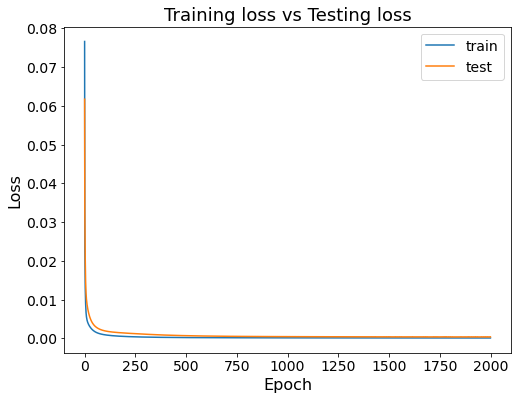

In [81]:
lr = 0.00001
EPOCHS = 2000
model_cnn.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=500)
mc = ModelCheckpoint('saved_model/cnn_shift_s{}_k{}_cp4.h5'.format(S, K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model_cnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [82]:
# model_cnn.save('saved_model/cnn_shift_s{}_k{}.h5'.format(S, K))

In [83]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/cnn_shift_s{}_k{}_cp4.h5'.format(S, K))

In [84]:
# model_load.predict(test_input).shape

### Performance

In [85]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19263, 192) (19263, 192)


In [86]:
# inv_y

In [87]:
# inv_yhat

In [88]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.0744
RMSE = 0.103
